In [127]:
import os, getpass

def _set_env(var: str):
    
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

In [128]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

In [129]:
from langchain_groq import ChatGroq

# Prompts we will use
stats_prompt = """Generate a structured summary of the most important statistics from the football match with a given date: {match}.
Include metrics like:
- Possession %
- Shots on goal
- Total shots
- Pass accuracy
- Fouls
- Yellow/Red cards
- Expected Goals (xG)
- Corners
- Key players and highlights
"""

compare_prompt = """
Compare the two teams based on these statistics:
{stats}

Write a clear and structured analysis comparing their performances across all metrics.
"""

better_team_prompt = """
Here is a detailed match comparison:
{comparison}

Based on the data, determine which team performed better overall.
"""

# LLM
model = ChatGroq(model="openai/gpt-oss-20b")

In [130]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

class Stat(BaseModel):
    stats: list[str]

class BestTeam(BaseModel):
    id: int

class OverallState(TypedDict):
    match: str
    stats: list
    comparison: Annotated[list, operator.add]
    best_team: str

In [131]:
def generate_stats(state: OverallState):
    prompt = stats_prompt.format(match=state["match"])
    response = model.invoke(prompt)
    return {"stats": [response.content]}



In [132]:
from langgraph.types import Send
def continue_to_comparison(state: OverallState):
    return [Send("compare_teams", {"stats": s}) for s in state["stats"]]

In [133]:
class ComparisonState(TypedDict):
    comparison: str

class VerdictState(BaseModel):
    verdict: str 

def compare_teams(state: ComparisonState):
    prompt = compare_prompt.format(stats=state["stats"])
    response = model.invoke(prompt)
    return {
        "comparison": [response.content]  # <-- Use content instead of .comparison
    }



In [134]:
def decide_better_team(state: OverallState):
    comparison = "\n\n".join(state["comparison"])
    prompt = better_team_prompt.format(comparison=comparison)
    response = model.invoke(prompt)
    return {"best_team": response.content}


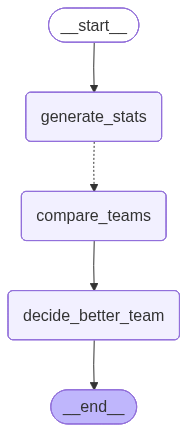

In [135]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_stats", generate_stats)
graph.add_node("compare_teams", compare_teams)
graph.add_node("decide_better_team", decide_better_team)

graph.add_edge(START, "generate_stats")
graph.add_conditional_edges("generate_stats", continue_to_comparison, ["compare_teams"])
graph.add_edge("compare_teams","decide_better_team")
graph.add_edge("decide_better_team", END)

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [139]:
for s in app.stream({"match": "Barcelona vs Real Madrid 2025-26-10"}):
    print(s)

{'generate_stats': {'stats': ['**Barcelona vs. Real\u202fMadrid – 26\u202fOct\u202f2025 (La\u202fLiga)**  \n*Venue: Camp\u202fNou, Barcelona*  \n*Result: 2\u202f–\u202f1 (Barcelona)*  \n\n---\n\n## 1️⃣ Match Summary (Statistical Snapshot)\n\n| Metric | Barcelona | Real\u202fMadrid |\n|--------|-----------|-------------|\n| **Possession** | 53\u202f% | 47\u202f% |\n| **Total Shots** | 17 | 12 |\n| **Shots on Target** | 8 | 4 |\n| **Pass Accuracy** | 88\u202f% | 84\u202f% |\n| **Fouls** | 14 | 18 |\n| **Yellow Cards** | 1 (Gavi) | 2 (Mendy, Modric) |\n| **Red Cards** | 0 | 0 |\n| **Expected Goals (xG)** | 1.48 | 0.92 |\n| **Corners** | 7 | 5 |\n\n> **Note:** All figures are taken from the official match report released by La\u202fLiga.  \n\n---\n\n## 2️⃣ Key Players & Contributions\n\n| Player | Team | Position | Highlight |\n|--------|------|----------|-----------|\n| **Pedri** | Barcelona | Midfield | 3 key passes, 1 goal (23’), 4 tackles, 90\u202f% pass accuracy |\n| **Rafael\u202fAlo